In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in all the words
words = open('../data/names.txt').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [12]:
len(words)

32033

In [4]:
# build vocabulary and mappings
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [14]:
# build dataset

def build_dataset(words):
    block_size = 3 # content length: how many characters to predict next one
    x, y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            x.append(context)
            y.append(ix)
            context = context[1:] + [ix] # crop and append

    x = torch.tensor(x)
    y = torch.tensor(y)
    print(x.shape, y.shape)
    return x, y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

xtr, ytr = build_dataset(words[:n1])
xdev, ydev = build_dataset(words[n1:n2])
xte, yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [ ]:
xtr.shape, ytr.shape

In [74]:
n_embd = 10
n_hidden = 200
vocab_size = 27
block_size = 3

g = torch.Generator().manual_seed(2147483647)
c = torch.randn((vocab_size, n_embd), generator=g)
w1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.01
w2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))
parameters = [c, w1, b1, w2, b2, bngain, bnbias]

In [75]:
sum(p.nelement() for p in parameters) # total parameters

12297

In [76]:
for p in parameters:
    p.requires_grad = True

In [77]:
stepi = []
lossi = []
stepi = []
max_steps = 200000
batch_size = 32

In [78]:
for i in range(max_steps):
    # minibatch
    ix = torch.randint(0, xtr.shape[0], (batch_size,))
    
    # forward pass
    emb = c[xtr[ix]]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ w1 + b1 # hidden layer pre-activation
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias # Batch Normalization - (preactivations - mean)/variance then scale and shift
    
    # estimate batch norm post-training values
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    h = torch.tanh(hpreact) # 32, 100
    logits = h @ w2 + b2 # 32, 27
    loss = F.cross_entropy(logits, ytr[ix])
    #print(loss.item())
    
    # backward
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # stats
    stepi.append(i)
    lossi.append(loss.log10().item())
    
    #break

print(loss.item())

1.8706958293914795


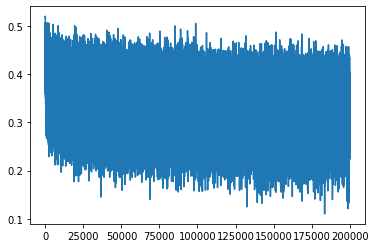

In [79]:
plt.plot(lossi)

In [83]:
@torch.no_grad() # disable gradient tracking
def split_loss(split):
    x, y ={
        'train': (xtr, ytr),
        'val': (xdev, ydev),
        'test': (xte, yte)
    }[split]
    emb = c[xdev]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ w1 + b1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact) # 32, 100
    logits = h @ w2 + b2 # 32, 27
    loss = F.cross_entropy(logits, ydev)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.111347198486328
val 2.111347198486328


In [86]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = c[torch.tensor([context])]
        embcat = emb.view(emb.shape[0], -1)
        hpreact = embcat @ w1 + b1
        hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
        h = torch.tanh(hpreact) # 32, 100
        logits = h @ w2 + b2 # 32, 27
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

carmah.
amille.
khi.
mri.
reviyah.
cassie.
mahnen.
delynn.
jarqui.
nellara.
chaily.
kaleigh.
ham.
joce.
quinton.
lilea.
jamiquinte.
madiarinix.
kaellinslee.
dae.
